In [1]:
import datetime
import glob
import os

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.stats as stats
import tensorflow as tf
from tqdm import tqdm

import utils

In [2]:
df = pd.read_csv('df_norm_2019.csv',parse_dates=['time'])
df = df[df['time'].isin(pd.date_range('2019-03-06','2019-12-31',freq='5min'))]
time = df['time']
df = df.drop('time',axis=1)
df

,p01i,snow,speed,weekday,hour
18408,0.000000,0.0,0.879870,1.0,0.000000
18409,0.000000,0.0,0.855736,1.0,0.000000
18410,0.000000,0.0,0.782553,1.0,0.000000
18411,0.000000,0.0,0.718189,1.0,0.000000
18412,0.000000,0.0,0.817607,1.0,0.000000
...,...,...,...,...,...
104682,0.542884,0.0,-0.609834,1.0,-0.398401
104683,0.542884,0.0,-0.624427,1.0,-0.398401
104684,0.542884,0.0,-0.687163,1.0,-0.398401
104685,0.542884,0.0,-0.718764,1.0,-0.398401


In [3]:
(train_df,val_df,test_df), num_features = utils.train_test_val_split(df)

In [4]:
input_width = 72
label_width = 72
shift = label_width 

In [5]:
w1 = utils.WindowGenerator(input_width, label_width, shift,train_df, val_df, test_df, label_columns=['speed'])
w1

Total window size: 144
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Label indices: [ 72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]
Label column name(s): ['speed']

In [6]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 144, 5)
Inputs shape: (3, 72, 5)
labels shape: (3, 72, 1)


In [7]:
w1.make_dataset(w1.train_df)

<MapDataset shapes: ((None, 72, 5), (None, 72, 1)), types: (tf.float32, tf.float32)>

In [8]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 72, 5)
Labels shape (batch, time, features): (32, 72, 1)


In [9]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [10]:
print('Input shape:', w1.example[0].shape)
print('Output shape:', linear(w1.example[0]).shape)

Input shape: (32, 72, 5)
Output shape: (32, 72, 1)


In [11]:
val_performance = {}
performance = {}

In [12]:
history = utils.compile_and_fit(linear, w1)

val_performance['Linear'] = linear.evaluate(w1.val)
performance['Linear'] = linear.evaluate(w1.test, verbose=0)

Epoch 1/20
1883/1883 [==============================] - 7s 4ms/step - loss: 0.6991 - mean_absolute_error: 0.6879 - val_loss: 0.7104 - val_mean_absolute_error: 0.6950
Epoch 2/20
1883/1883 [==============================] - 7s 4ms/step - loss: 0.6470 - mean_absolute_error: 0.6570 - val_loss: 0.7071 - val_mean_absolute_error: 0.6919
Epoch 3/20
1883/1883 [==============================] - 13s 7ms/step - loss: 0.6467 - mean_absolute_error: 0.6567 - val_loss: 0.7076 - val_mean_absolute_error: 0.6922
Epoch 4/20
535/535 [==============================] - 2s 4ms/step - loss: 0.7077 - mean_absolute_error: 0.6921


In [13]:
performance['Linear']

[0.7738441824913025, 0.7189756035804749]

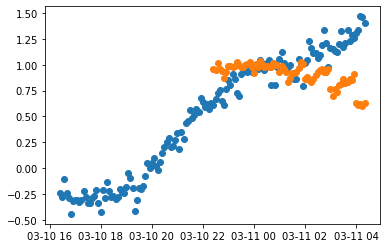

In [116]:
# plt.plot()
ind_0 = np.random.randint(0,len(df)-1)
width = 72

prediction = linear.predict(df[ind_0:ind_0+width])

plt.scatter(time[ind_0:ind_0+2*width],df[ind_0:ind_0+2*width]['speed'].values)

plt.scatter(time[ind_0+width:ind_0+2*width],prediction)

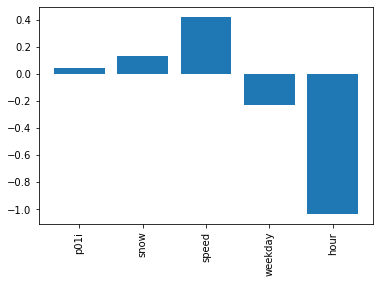

In [15]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [16]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = utils.compile_and_fit(dense, w1)

val_performance['Dense'] = dense.evaluate(w1.val)
performance['Dense'] = dense.evaluate(w1.test, verbose=0)

Epoch 1/20
1883/1883 [==============================] - 25s 13ms/step - loss: 0.4044 - mean_absolute_error: 0.4824 - val_loss: 0.4771 - val_mean_absolute_error: 0.5286
Epoch 2/20
1883/1883 [==============================] - 20s 10ms/step - loss: 0.3626 - mean_absolute_error: 0.4494 - val_loss: 0.4496 - val_mean_absolute_error: 0.5002
Epoch 3/20
1883/1883 [==============================] - 22s 12ms/step - loss: 0.3519 - mean_absolute_error: 0.4423 - val_loss: 0.4319 - val_mean_absolute_error: 0.4996
Epoch 4/20
1883/1883 [==============================] - 22s 12ms/step - loss: 0.3374 - mean_absolute_error: 0.4342 - val_loss: 0.4279 - val_mean_absolute_error: 0.4959
Epoch 5/20
1883/1883 [==============================] - 19s 10ms/step - loss: 0.3177 - mean_absolute_error: 0.4238 - val_loss: 0.3841 - val_mean_absolute_error: 0.4765
Epoch 6/20
1883/1883 [==============================] - 20s 11ms/step - loss: 0.3017 - mean_absolute_error: 0.4138 - val_loss: 0.3650 - val_mean_absolute_error:

In [33]:
test_case[(test_case['p01i']>0) & (test_case['weekday']>0)].index.values

array([ 96456,  96457,  96458, ..., 104684, 104685, 104686])

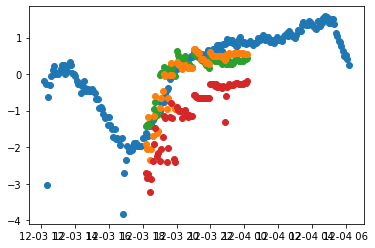

In [170]:
test_case = w1.test_df
inds = test_case[(test_case['p01i']>0) & (test_case['weekday']>0) & (test_case['snow']>0)].index
ind_0 = np.random.randint(0,len(inds)-1)
ind_0 = inds[ind_0]


plt.scatter(time.loc[ind_0:ind_0+3*width],df.loc[ind_0:ind_0+3*width]['speed'].values)



df_prec = df.loc[ind_0:ind_0+width].copy()
df_prec['p01i'] = 0
df_prec['snow'] = 0
prediction = dense.predict(df_prec)

plt.scatter(time.loc[ind_0+width:ind_0+2*width],prediction,label='no snow',c='tab:green')

prediction = dense.predict(df.loc[ind_0:ind_0+width])
plt.scatter(time.loc[ind_0+width:ind_0+2*width],prediction,label='observed snow',c='tab:orange')

df_prec = df.loc[ind_0:ind_0+width].copy()
df_prec['p01i'] = 1
prediction = dense.predict(df_prec)
plt.scatter(time.loc[ind_0+width:ind_0+2*width],prediction,label='heavy snow',c='tab:red')